# Making trackpy fast(er)

This notebook explains specific features built into `trackpy` to boost performance, and it also provides some general suggestions on how to make particle tracking run faster.

First, set up matplotlib...

In [1]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

## General advice

### Subnetworks

As we'll see in the examples below, the need to resolve "subnetworks" — in which multiple neighboring particles in one frame could correspond to multiple particles in the next — can drastically slow down tracking. There is a seprate tutorial on dealing with (excessive) subnetworks. In the text below, we'll look at some methods for finding out just how much a of a problem subnetworks are in your application, so that you can weigh the various remedies against a potential loss of accuracy.

### Feature-finding: The best advice

Judicious use of the `minmass` and/or `threshold` parameters during feature-finding, as described in the "walkthrough" tutorial notebook, can considerably speed up feature-finding, linking, and analysis of tracks. The best way to speed up a computation is usually to avoid doing it at all.

### Feature-finding: The details

The `locate()` and `batch()` functions for feature-finding can use either of two engines for their work, as specified by the optional `engine` parameter:

- The `numba` engine is reasonably fast. It is the default when numba is installed.
- The `python` engine is currently slightly more accurate, but considerably slower.

In addition, both engines do some extra work that you might not always need:

- They iteratively try to refine the position of the feature centroid, for the best possible subpixel accuracy. This can be turned off with the parameter `max_iterations=0`.
- They compute extra data about the feature, such as its eccentricity. This can be turned off with `characterize=False`.

**Note:** Before sacrificing accuracy for performance, it's best to know objectively how much performance you are gaining. Read on to the Advanced Topics section for information about how to time feature-finding.

## Using numba for acceleration

Two key algorithms in `trackpy` can be sped up by the [`numba`](http://numba.pydata.org) array-based just-in-time compiler for Python:

- Iteratively refining the centroids of features, for better subpixel resolution.
- Resolving subnetworks, as part of the linking process.

The source code actually contains distinct Python and numba versions of each — and not one numba version but several, each optimized for a different use, and for 2D and 3D images. The default setting is to use the appropriate numba version when possible, but to fall back on the general-purpose Python version if numba is unavailable. You can also control these choices manually, using the `engine` argument to `locate()`, and the `link_strategy` argument when linking.

If you don't have `numba`, we recommend using the Anaconda or Canopy scientific Python distributions, which include `numba` and many other useful packages. Note that it can be difficult to install outside of these distributions.

### Theoretical performance diagnostics: `performance_report()`

`trackpy` provides an easy way to check whether your system is configured for the best performance. Currently, it reports only whether `numba` is working.

In [2]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


## Advanced topics

### Empirical performance diagnostics: Timing and profiling

What follows is a crash course in how to evaluate the performance of tracking. The general suggestions given above are good starting points, but they are just that — general suggestions. For your *specific* application, you need *specific* data about how long the computation takes, and how the computer is spending its time. This information may help you make your own adjustments to your tracking method, or it may help you when asking the `trackpy` developers for assistance (chances are we'll be happy to help!).

You will use these techniques with your own data, but let's use the data from the "walkthrough" tutorial.

### Setup

In [3]:
import trackpy as tp
import pims

In [4]:
frames_raw = pims.open('../sample_data/bulk_water/*.png')

# Convert each image from color to greyscale
@pims.pipeline
def as_grey(img):
    return img[:,:,1]  # Green channel


frames = as_grey(frames_raw)  # PIMS pipelines work on entire movies

The speed at which we can read images from disk is not something we can hope to improve much, so let's get that out of the way before we do our tests. Also, we don't need to use all the frames for this example (though you're welcome to).

In [5]:
# This gets the image data out of the pims ImageSequence object, and into a good old list in memory.
frames_preload = list(frames[:50])

Just so we don't forget what these images look like:

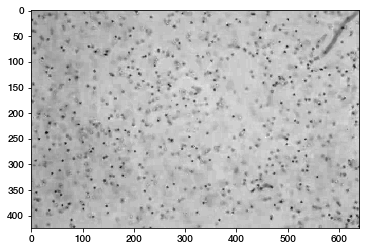

In [6]:
imshow(frames_preload[0], cmap=matplotlib.cm.gray);

Before we identify features, we need to give `trackpy` a chance to "warm up" and compile certain functions, if it hasn't done so already. So we'll find features in just 2 frames: 

In [7]:
f2 = tp.batch(frames_preload[:3], 11, minmass=100, invert=True)
_ = tp.batch(frames_preload[:3], 11, minmass=100, invert=True, characterize=False)

Frame 2: 494 features


### Timing

Let's find out — precisely — how long it takes to find features in a single frame. You'll notice that the following cell begins with the line `%%timeit`. This is an example of a *cell magic*, which gives IPython special instructions about how to run the rest of the cell.

In [8]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=0.03, invert=True)

Frame 0: 535 features
38.9 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`%%timeit` runs the same code multiple times and returns a somewhat accurate measurement of execution time. We can use it to see how much faster we can find features in this image when we turn off centroid refinement and feature characterization:

In [9]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=0.03, invert=True, 
              max_iterations=1, characterize=False)

Frame 0: 538 features
25.9 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


One thing to note is that the ratio of features to pixels is rather low in this image. If you were finding features in a dense packing of particles, the timing difference could be much more significant.

### Profiling

Next, we'll try to get a sense of what's taking so long. The `%%prun` cell magic instructs IPython to run the rest of the cell's code using a *profiler*.

In [10]:
%prun f = tp.batch(frames_preload, 11, minmass=0.03, invert=True)

Frame 49: 608 features
 

When execution is complete, a pager will pop up in the lower portion of the notebook window. This is the profiler output. We reproduce a portion of it here. Your results will depend on your data and the computer you are using.

```
         449300 function calls (443235 primitive calls) in 1.726 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    0.268    0.005    0.268    0.005 {built-in method scipy.ndimage._nd_image.binary_erosion}
      100    0.233    0.002    0.233    0.002 {built-in method scipy.ndimage._nd_image.correlate1d}
      100    0.229    0.002    0.229    0.002 {built-in method scipy.ndimage._nd_image.min_or_max_filter1d}
      100    0.117    0.001    0.117    0.001 {built-in method scipy.ndimage._nd_image.uniform_filter1d}
      200    0.115    0.001    0.115    0.001 {method 'nonzero' of 'numpy.ndarray' objects}
      200    0.066    0.000    0.066    0.000 {built-in method numpy.where}
     1852    0.041    0.000    0.041    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       50    0.035    0.001    0.036    0.001 preprocessing.py:145(invert_image)
       50    0.029    0.001    0.029    0.001 center_of_mass.py:362(_numba_refine_2D_c)
       50    0.028    0.001    0.028    0.001 {method 'partition' of 'numpy.ndarray' objects}
       50    0.026    0.001    0.182    0.004 find.py:66(percentile_threshold)
       50    0.025    0.000    0.438    0.009 preprocessing.py:86(bandpass)
5646/5396    0.024    0.000    0.028    0.000 {built-in method numpy.array}
      884    0.020    0.000    0.020    0.000 {method 'acquire' of '_thread.lock' objects}
    64626    0.018    0.000    0.032    0.000 {built-in method builtins.isinstance}
       50    0.017    0.000    0.481    0.010 find.py:75(grey_dilation)
       50    0.017    0.000    0.306    0.006 uncertainty.py:12(measure_noise)
       50    0.015    0.000    0.015    0.000 {method 'query_pairs' of 'scipy.spatial.ckdtree.cKDTree' objects}
    28360    0.009    0.000    0.012    0.000 generic.py:7(_check)
       50    0.009    0.000    0.044    0.001 find.py:19(where_close)
      400    0.008    0.000    0.008    0.000 socket.py:342(send)
      350    0.008    0.000    0.008    0.000 {method 'astype' of 'numpy.ndarray' objects}
      100    0.008    0.000    0.031    0.000 preprocessing.py:180(convert_to_int)
       50    0.008    0.000    0.008    0.000 {method 'clip' of 'numpy.ndarray' objects}
  500/400    0.008    0.000    0.049    0.000 base.py:277(__new__)
    45270    0.008    0.000    0.009    0.000 {built-in method builtins.getattr}
       50    0.007    0.000    1.639    0.033 feature.py:208(locate)
```

This is a record of how the computer spent its time while finding features. The various numbers are explained in the [documentation for the Python `profiler` module](http://docs.python.org/2/library/profile.html#instant-user-s-manual). You shouldn't try to understand every line, but you can get some idea of which functions are called for each frame (multiples of 50), and which are called for each particle. Note that `{functions in braces}` are written in C, not Python, are not part of `trackpy`, and tend to be less user-serviceable. (They are typically `scipy` or `numpy` functions.)

Now let's look at the linking step. Once again, we'll prime `trackpy`, to avoid distorting our results with one-time setup code:

In [11]:
# Use a large search_range, to be sure that numba subnet code is compiled and used.
t1 = tp.link(f2, 5, memory=3)

Frame 2: 494 trajectories present.


To make sure that the subnet linker gets a workout, let's use a large `search_range`:

In [12]:
%%prun
t = tp.link(f, 15, memory=3)

Frame 49: 608 trajectories present.
 

```
         1046100 function calls (1035220 primitive calls) in 1.267 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2171    0.115    0.000    0.195    0.000 subnetlinker.py:177(numba_link)
    29643    0.088    0.000    0.105    0.000 utils.py:109(__init__)
       49    0.082    0.002    0.288    0.006 subnet.py:358(compute)
       49    0.077    0.002    0.077    0.002 subnet.py:348(reset)
31459/31458    0.067    0.000    0.068    0.000 {built-in method numpy.array}
14757/5012    0.063    0.000    0.069    0.000 subnetlinker.py:50(do_recur)
    52733    0.049    0.000    0.059    0.000 subnet.py:238(assign_subnet)
    35275    0.046    0.000    0.046    0.000 linking.py:310(_sort_key_spl_dpl)
       49    0.042    0.001    0.047    0.001 {method 'query' of 'scipy.spatial.ckdtree.cKDTree' objects}
       49    0.040    0.001    0.431    0.009 linking.py:519(assign_links)
    16315    0.038    0.000    0.352    0.000 subnetlinker.py:430(subnet_linker_numba)
       50    0.029    0.001    0.134    0.003 utils.py:29(<listcomp>)
       49    0.028    0.001    0.116    0.002 linking.py:537(apply_links)
       49    0.026    0.001    0.072    0.001 {built-in method builtins.sorted}
    37548    0.023    0.000    0.034    0.000 {method 'sort' of 'list' objects}
     2171    0.023    0.000    0.023    0.000 subnetlinker.py:241(_numba_subnet_norecur)
      834    0.020    0.000    0.020    0.000 {method 'acquire' of '_thread.lock' objects}
       98    0.017    0.000    0.092    0.001 subnet.py:122(rebuild)
     5012    0.017    0.000    0.099    0.000 subnetlinker.py:28(__init__)
       49    0.017    0.000    1.067    0.022 linking.py:511(next_level)
```

Note the time spent on `numba_link` at the beginning of the report, and a little farther down, the large `cumtime` for `subnet.py:358(compute)` (which includes the `numba_link` time). These are parts of the subnet resolution code referred to above. 

In this example, the `cumtime` for subnets is a large enough fraction of the total linking time that you may want to look at ways to reduce it. The tutorials on Prediction, Advanced Linking, and Adaptive Linking offer some methods for reducing `search_range` while still obtaining good or better results.

### Neighbor-finding strategy: KDTree

An important operation in tracking (i.e. linking) is finding all the particles that are close to a certain point in space. `trackpy` has two ways of doing this:

- A KDTree, which only handles more standard cases (e.g. Euclidean geometries) and is written in C. (This is the default.)
- A BTree ("ball tree") based on the scikit-learn package. It is very extensible but tends to be slower. The `dist_func` argument to `link()` measures distances in your custom coordinate space.

The method is set by the `neighbor_strategy` argument to the various linking functions, which again defaults to KDTree. The KDTree is a standard part of `scipy`; if you can run `trackpy` at all, it is enabled.

--------

Well, I hope you've enjoyed this brief tour of `trackpy` performance. Just remember that if you come up with new ways to improve performance, the `trackpy` community will be interested!